In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),  
        'population': Dataset.get_population_by_country_state(country, state),
    }
    
    MODEL_PARAMETERS = {        
        'model': 'seir',

        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        'presymptomatic_period': 3, # Time before exposed are infectious, In days
        'duration_mild_infections': 6, # Time mildly infected people stay sick before hospitalization or recovery, In days
        'hospital_time_recovery': 6, #Duration of hospitalization before icu or recovery, In days
        'icu_time_death': 8, #Time from ICU admission to death, In days

        'beta': 0.6,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,

        'hospitalization_rate': 0.20, # AH 80% proportion mild - becomed 15% fraction_severe when critical taken out
        'hospitalized_cases_requiring_icu_care': 0.25, # AH 5% critical, adjusted to be % of hospitalized that become critical - becomes 5% faction_critical
        'case_fatality_rate': 0.02, # AH
        
        'exposed_from_infected': True,

        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
        'observed_daily_growth_rate': 1.21,
    }
    
    MODEL_PARAMETERS['beta'] = (0.3 + ( (MODEL_PARAMETERS["observed_daily_growth_rate"] - 1.09) / 0.02) * 0.05)
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)
             
INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 5, 18): None
    },   
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): None

    },
    {
        datetime.date(2020, 3, 3): 5,
    },
]

In [5]:
#JHUDataset.get_timeseries_by_country_state('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#Dataset.get_beds_by_country_state('USA', 'NY')

In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [7]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40873 entries, 0 to 40872
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      40873 non-null  int64         
 1   date       40873 non-null  datetime64[ns]
 2   country    40873 non-null  object        
 3   state      35917 non-null  object        
 4   county     31651 non-null  object        
 5   cases      40854 non-null  float64       
 6   deaths     40432 non-null  float64       
 7   recovered  40485 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 2.5+ MB
0.15000000000000002
0.05
{"beta": [0, 2.0692594234332788e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.3333333333333333, "gamma": [0, 0.13333333333333333, 0.125, 0.07500000000000001], "rho": [0, 0.033333333333333326, 0.041666666666666664], "mu": 0.049999999999999996}
3.759999999999998


first case
2020-03-03 00:00:00
peak in hospitalizations
2020-05-18T00:00:00.000000000
avg doubling time by month
       doubling_time
month               
3               0.00
4               5.34
5             -23.55
6              -6.85
7              -5.81
8              -5.78
9              -5.89
10             -6.01
11             -6.08
12             -6.12
avg doubling time by week
      doubling_time
week               
10              nan
11              nan
12              nan
13              nan
14            13.30
15             3.46
16             3.04
17             3.09
18             3.42
19             4.91
20            16.05
21          -115.21
22           -11.58
23            -8.12
24            -6.97
25            -6.42
26            -6.13
27            -5.96
28            -5.85
29            -5.79
30            -5.76
31            -5.75
32            -5.75
33            -5.76
34            -5.78
35            -5.81
36            -5.84
37            -5.87
38       

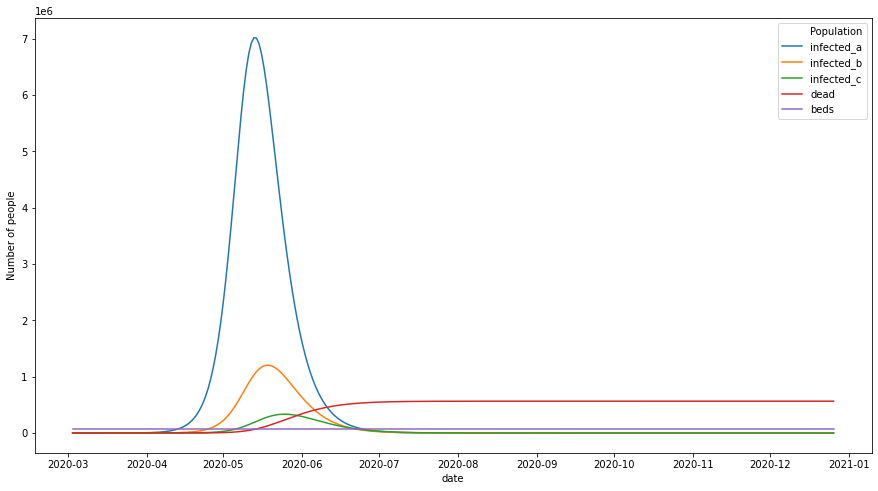

In [8]:
first_case_date = df.loc[(df.infected > 0), 'date'].min()
peak_date = df.loc[(df.infected_b == df.infected_b.max())]['date'].values[0]

print('first case')
print(first_case_date)
print('peak in hospitalizations')
print(peak_date)

df['month'] = pd.DatetimeIndex(df['date']).month
avg_doubling_month = df.loc[:, ('month', 'doubling_time')].groupby('month').mean()

print('avg doubling time by month')
print(avg_doubling_month)

df['week'] = pd.DatetimeIndex(df['date']).week
avg_doubling_month = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(df, chart_cols)

In [9]:
# df.head(25)

In [10]:
[intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

0.15000000000000002
0.05
{"beta": [0.0, 8.04759446965108e-10, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.3333333333333333, "gamma": [0, 0.13333333333333333, 0.125, 0.07500000000000001], "rho": [0, 0.033333333333333326, 0.041666666666666664], "mu": 0.049999999999999996}
0.3000082549469565


first case
2020-03-03 00:00:00
peak in hospitalizations
2020-07-16T00:00:00.000000000
avg doubling time by month
       doubling_time
month               
3                inf
4            -711.60
5             -95.22
6               3.11
7              -8.70
8              -6.63
9              -5.80
10             -5.78
11             -5.90
12             -6.01
avg doubling time by week
      doubling_time
week               
10              nan
11              nan
12              nan
13              nan
14              inf
15           -29.36
16           -11.79
17           -10.40
18           -56.40
19          -154.93
20           -47.77
21          -185.03
22             3.54
23             3.03
24             3.01
25             3.05
26             3.23
27             4.03
28             8.17
29           -27.00
30           -16.01
31            -9.02
32            -7.32
33            -6.60
34            -6.23
35            -6.02
36            -5.89
37            -5.81
38       

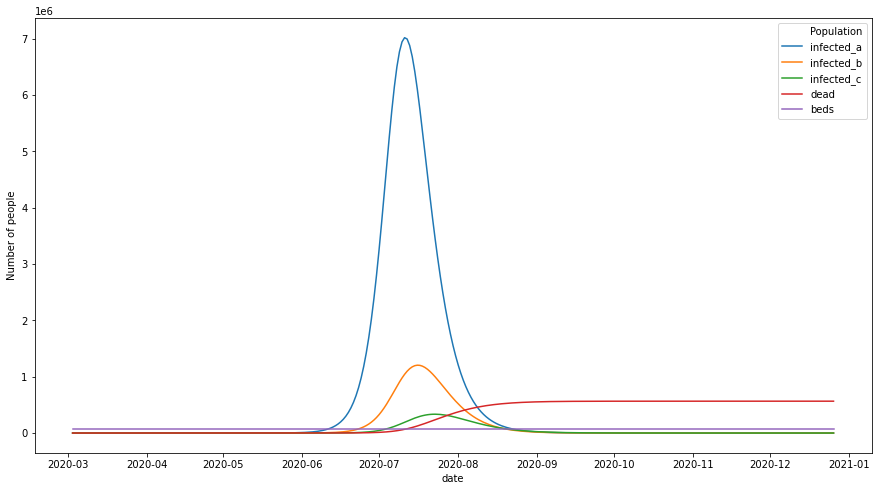

In [11]:
first_case_date = intervention_df.loc[(intervention_df.infected > 0), 'date'].min()
peak_date = intervention_df.loc[(intervention_df.infected_b == intervention_df.infected_b.max())]['date'].values[0]

print('first case')
print(first_case_date)
print('peak in hospitalizations')
print(peak_date)

intervention_df['month'] = pd.DatetimeIndex(intervention_df['date']).month
avg_doubling_month = intervention_df.loc[:, ('month', 'doubling_time')].groupby('month').mean()

print('avg doubling time by month')
print(avg_doubling_month)

intervention_df['week'] = pd.DatetimeIndex(intervention_df['date']).week
avg_doubling_month = intervention_df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(intervention_df, chart_cols)